In [2]:
import pandas as pd
import numpy as np

df=pd.read_csv("../course_3_data/amazon_baby_subset.csv")
df = df.fillna({'review':''}) 

# Removing Punctuations


In [3]:
def remove_punctuation(text):
    import string
    translation = text.maketrans("","",string.punctuation)

    return text.translate(translation) 

df['review_clean'] = df['review'].apply(remove_punctuation)

# Importing important words

In [4]:
important_words=pd.read_json("../course_3_data/important_words.json")
important_words=important_words[0]
important_words


0        baby
1         one
2       great
3        love
4         use
        ...  
188    babies
189       won
190       tub
191    almost
192    either
Name: 0, Length: 193, dtype: object

In [5]:
for word in important_words:
    df[word] = df['review_clean'].apply(lambda s : s.split().count(word))


In [6]:
train=pd.read_json("../course_3_data/module-4-assignment-train-idx.json")
valid=pd.read_json("../course_3_data/module-4-assignment-validation-idx.json")

In [7]:
train_data=df.iloc[train[0].values.reshape((-1,))]
validation_data=df.iloc[valid[0].values.reshape((-1,))]

In [8]:
def get_numpy_data(dataframe, features, label):
    dataframe['constant'] = 1
    features =np.insert(features,0,'constant')
    features_frame = dataframe[features]
    feature_matrix = features_frame.to_numpy()
    label_sarray = dataframe[label]
    label_array = label_sarray.to_numpy()
    return(feature_matrix, label_array)

In [9]:
feature_matrix_train, sentiment_train = get_numpy_data(train_data, important_words.values, 'sentiment')
feature_matrix_valid, sentiment_valid = get_numpy_data(validation_data, important_words.values, 'sentiment') 

/home/prachi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [10]:
import math
def predict_probability(feature_matrix, coefficients):
    # Take dot product of feature_matrix and coefficients  
    # YOUR CODE HERE
    score = np.dot(feature_matrix,coefficients)
    
    # Compute P(y_i = +1 | x_i, w) using the link function
    # YOUR CODE HERE
    predictions=[]
    for i in score:
        predictions.append(1/(1+math.exp(-i)))
    
    # return predictions
    return predictions

In [11]:
def feature_derivative_with_L2(errors, feature, coefficient, l2_penalty, feature_is_constant): 
    
    # Compute the dot product of errors and feature
    ## YOUR CODE HERE
    derivative = np.dot(errors,feature)

    # add L2 penalty term for any feature that isn't the intercept.
    if not feature_is_constant: 
        ## YOUR CODE HERE
        derivative=derivative-2*l2_penalty*coefficient
        
    return derivative

In [12]:
def compute_log_likelihood_with_L2(feature_matrix, sentiment, coefficients, l2_penalty):
    indicator = (sentiment==+1)
    scores = np.dot(feature_matrix, coefficients)
    lp = np.sum((indicator-1)*scores - np.log(1. + np.exp(-scores))) - l2_penalty*np.sum(coefficients[1:]**2)
    return lp

In [13]:
def logistic_regression_with_L2(feature_matrix, sentiment, initial_coefficients, step_size, l2_penalty, max_iter):
    coefficients = np.array(initial_coefficients) 
    # make sure it's a numpy array
    for itr in range(max_iter):
        # Predict P(y_i = +1|x_i,w) using your predict_probability() function
        ## YOUR CODE HERE
        predictions = predict_probability(feature_matrix,coefficients)
        
        # Compute indicator value for (y_i = +1)
        indicator = (sentiment==+1)
        
        # Compute the errors as indicator - predictions
        errors = indicator - predictions
        for j in range(len(coefficients)): # loop over each coefficient
            is_intercept = (j == 0)
            # Recall that feature_matrix[:,j] is the feature column associated with coefficients[j].
            # Compute the derivative for coefficients[j]. Save it in a variable called derivative
            ## YOUR CODE HERE
            
            derivative = feature_derivative_with_L2(errors,feature_matrix[:,j],coefficients[j],l2_penalty,is_intercept)

            # add the step size times the derivative to the current coefficient
            ## YOUR CODE HERE
            coefficients[j]=coefficients[j]+step_size*derivative
            
        # Checking whether log likelihood is increasing
#         if itr <= 15 or (itr <= 100 and itr % 10 == 0) or (itr <= 1000 and itr % 100 == 0) \
#         or (itr <= 10000 and itr % 1000 == 0) or itr % 10000 == 0:
#             lp = compute_log_likelihood_with_L2(feature_matrix, sentiment, coefficients, l2_penalty)
#             print('iteration %*d: log likelihood of observed labels = %.8f' % \
#                 (int(np.ceil(np.log10(max_iter))), itr, lp))
    return coefficients

In [14]:
feature_matrix=feature_matrix_train
sentiment=sentiment_train
initial_coefficients = np.zeros(194)
step_size = 5e-6
max_iter = 501
penalties=[0, 4, 10, 1e2, 1e3,1e5]

In [15]:
feature_matrix_train.shape

(42361, 194)

In [16]:
coefficients_0_penalty=logistic_regression_with_L2(feature_matrix, sentiment, initial_coefficients, step_size,0, max_iter)

coefficients_4_penalty =logistic_regression_with_L2(feature_matrix, sentiment, initial_coefficients, step_size, penalties[1], max_iter)

coefficients_10_penalty=logistic_regression_with_L2(feature_matrix, sentiment, initial_coefficients, step_size, penalties[2], max_iter)

coefficients_1e2_penalty=logistic_regression_with_L2(feature_matrix, sentiment, initial_coefficients, step_size, penalties[3], max_iter)

coefficients_1e3_penalty=logistic_regression_with_L2(feature_matrix, sentiment, initial_coefficients, step_size, penalties[4], max_iter)

coefficients_1e5_penalty=logistic_regression_with_L2(feature_matrix, sentiment, initial_coefficients, step_size, penalties[5], max_iter)


In [17]:
coefficients_0_penalty

array([-6.37421352e-02,  7.40730059e-02,  1.27525058e-02,  8.01624990e-01,
        1.05855398e+00, -1.04152191e-04, -2.87021444e-01, -3.38447399e-03,
        9.84558820e-01,  5.24419456e-01, -8.69675407e-02,  2.08912434e-01,
        4.53866487e-01, -1.96835211e-01,  1.58163325e-01, -1.79058177e-02,
        1.28396325e-01, -7.24293854e-02, -1.51817046e-01, -2.63330304e-01,
        1.56507228e-01,  2.63417760e-01, -1.32474753e-02,  1.05248405e+00,
       -3.75326583e-02, -3.29713873e-04, -6.79948371e-02,  1.93363694e-01,
        1.88508247e-01, -2.68954361e-01,  9.62841996e-02,  3.58309842e-01,
       -4.63096879e-02, -3.68678195e-01,  8.35693208e-01,  4.29393687e-01,
       -6.53274724e-03, -1.18953292e-01,  4.52597544e-02, -1.05433750e-01,
       -1.40179533e-01,  1.15329513e-01,  4.70226839e-02,  2.77177536e-02,
       -1.93377062e-01,  2.65797426e-01,  7.83957751e-02, -1.76600523e-01,
        3.61782536e-01,  1.02765639e-01, -2.71592217e-01,  2.60319903e-01,
        3.39154885e-01, -

In [25]:
table1=pd.DataFrame([coefficients_0_penalty,coefficients_4_penalty,coefficients_10_penalty,coefficients_1e2_penalty,coefficients_1e3_penalty,coefficients_1e5_penalty])
imp=np.insert(important_words.values,0,'intercept')
table1.columns=imp
table1.index=penalties
table=table1.T
table=table.reset_index()
table.rename(columns={'index':'word'},inplace=True)
table



,word,0.0,4.0,10.0,100.0,1000.0,100000.0
0,intercept,-0.063742,-0.063143,-0.062256,-0.050438,0.000054,0.011362
1,baby,0.074073,0.073994,0.073877,0.072360,0.059752,0.001784
2,one,0.012753,0.012495,0.012115,0.007247,-0.008761,-0.001827
3,great,0.801625,0.796897,0.789935,0.701425,0.376012,0.008950
4,love,1.058554,1.050856,1.039529,0.896644,0.418354,0.009042
...,...,...,...,...,...,...,...
189,babies,0.052494,0.052130,0.051594,0.044805,0.021026,0.000365
190,won,0.004960,0.004907,0.004830,0.003848,0.001084,0.000017
191,tub,-0.166745,-0.165367,-0.163338,-0.137693,-0.054778,-0.000936
192,almost,-0.031916,-0.031621,-0.031186,-0.025604,-0.007361,-0.000125


In [19]:
negative_words=table.sort_values(table.columns[1],ascending=True)['word'][:5].tolist()
positive_words=table.sort_values(table.columns[1],ascending=False)['word'][:5].tolist()
print(positive_words)
print(negative_words)

['love', 'loves', 'easy', 'perfect', 'great']
['disappointed', 'money', 'return', 'waste', 'returned']


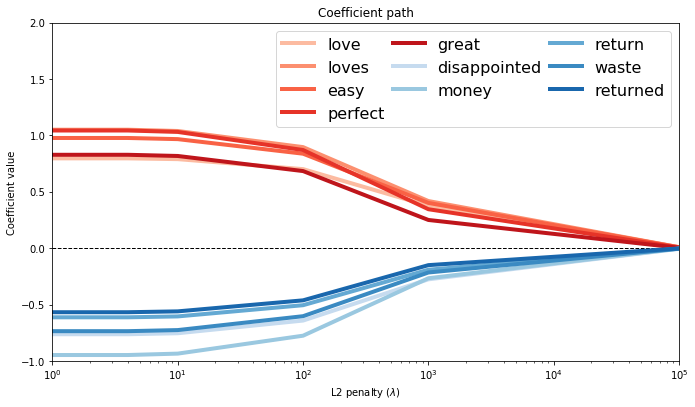

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 10, 6

def make_coefficient_plot(table, positive_words, negative_words, l2_penalty_list):
    cmap_positive = plt.get_cmap('Reds')
    cmap_negative = plt.get_cmap('Blues')
    
    xx = l2_penalty_list
    plt.plot(xx, [0.]*len(xx), '--', lw=1, color='k')
    
    table_positive_words = table[table['word'].isin(positive_words)]
    table_negative_words = table[table['word'].isin(negative_words)]
    del table_positive_words['word']
    del table_negative_words['word']
#     table_positive_words=table[positive_words.index]
#     table_negative_words=table[negative_words.index]
    
    
    for i in range(len(positive_words)):
        color = cmap_positive(0.8*((i+1)/(len(positive_words)*1.2)+0.15))
        plt.plot(xx, table_positive_words[i:i+1].to_numpy().flatten(),
                 '-', label=positive_words[i], linewidth=4.0, color=color)
        
    for i in range(len(negative_words)):
        color = cmap_negative(0.8*((i+1)/(len(negative_words)*1.2)+0.15))
        plt.plot(xx, table_negative_words[i:i+1].to_numpy().flatten(),
                 '-', label=negative_words[i], linewidth=4.0, color=color)
    plt.legend(loc='best', ncol=3, prop={'size':16}, columnspacing=0.5)
    plt.axis([1, 1e5, -1, 2])
    plt.title('Coefficient path')
    plt.xlabel('L2 penalty ($\lambda$)')
    plt.ylabel('Coefficient value')
    plt.xscale('log')
    plt.rcParams.update({'font.size': 18})
    plt.tight_layout()


make_coefficient_plot(table, positive_words, negative_words, l2_penalty_list=[0, 4, 10, 1e2, 1e3, 1e5])


In [21]:
def predict_sentiment(feature_matrix,coefficients):
    predictions=[]
    scores=np.dot(feature_matrix,coefficients)
    for i in scores:
        if i>0:
            predictions.append(1)
        else:
            predictions.append(-1)
    return predictions
    

In [22]:
def accuracy(df,predictions):
    true_predictions = df[df['sentiment'] == predictions]
    accuracy=len(true_predictions)/len(df)
    return accuracy


In [23]:
predictions=predict_sentiment(feature_matrix,coefficients_0_penalty)
print(accuracy(train_data,predictions))
predictions=predict_sentiment(feature_matrix,coefficients_4_penalty)
print(accuracy(train_data,predictions))
predictions=predict_sentiment(feature_matrix,coefficients_10_penalty)
print(accuracy(train_data,predictions))
predictions=predict_sentiment(feature_matrix,coefficients_1e2_penalty)
print(accuracy(train_data,predictions))
predictions=predict_sentiment(feature_matrix,coefficients_1e3_penalty)
print(accuracy(train_data,predictions))
predictions=predict_sentiment(feature_matrix,coefficients_1e5_penalty)
print(accuracy(train_data,predictions))

0.7851561577866434
0.7851089445480512
0.7849909114515711
0.7839758268218409
0.7758551497839994
0.6803663747314747


In [24]:
predictions=predict_sentiment(feature_matrix_valid,coefficients_0_penalty)
print(accuracy(valid_data,predictions))
predictions=predict_sentiment(feature_matrix_valid,coefficients_4_penalty)
print(accuracy(valid_data,predictions))
predictions=predict_sentiment(feature_matrix_valid,coefficients_10_penalty)
print(accuracy(valid_data,predictions))
predictions=predict_sentiment(feature_matrix_valid,coefficients_1e2_penalty)
print(accuracy(valid_data,predictions))
predictions=predict_sentiment(feature_matrix_valid,coefficients_1e3_penalty)
print(accuracy(valid_data,predictions))
predictions=predict_sentiment(feature_matrix_valid,coefficients_1e5_penalty)
print(accuracy(valid_data,predictions))

NameError: name 'valid_data' is not defined